[View in Colaboratory](https://colab.research.google.com/github/KHATUNA3/Week3_public/blob/master/02TextureClassificationWithConvNets.ipynb)

# Tissue Classification using Neural Networks
In this lab we will explore the use of texture in images and traditional machine learning approaches such as clustering. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

In [0]:
# Imports
from __future__ import print_function
import os
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

## Step 1
* Load the data (done for you)
 * The "data" variable stores 5000 images of shape 150x150. This means data has shape (5000, 150, 150). These images are loaded here as grayscale.
 * The "labels" variable stores 5000 labels (0-7). This means "labels" has shape (5000,)
* Split data into training and testing subsets (left up to you)
 * Check out the sklearn function train_test_split from sklearn.model_selection

In [2]:
! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git

# Build the path to the data folder. No need to change directories
# There are a total of 6 files you will have to load
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')

fatal: destination path 'Week3_public' already exists and is not an empty directory.


In [3]:
# Load data and split into training, testing sets
y = np.load(os.path.join(data_dir, 'rgb01.npz'))
labels = y['labels']
data = y['rgb_data']
data = data[:,:,:,0]
label_str = y['label_str']
label_str = label_str.tolist() # this is to convert label_str back to a dictionary
y = []

print(data.shape)
for ii in range(2,6):
    filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
    print('loading ', filename)
    y = np.load(filename)
    labels = np.append(labels, y['labels'], axis=0)
    data = np.append(data, y['rgb_data'][:,:,:,0], axis=0)
    print(data.shape)
    y = []


print( data.shape )
print( labels.shape )

(1000, 150, 150)
loading  /content/Week3_public/data/crc/rgb02.npz
(2000, 150, 150)
loading  /content/Week3_public/data/crc/rgb03.npz
(3000, 150, 150)
loading  /content/Week3_public/data/crc/rgb04.npz
(4000, 150, 150)
loading  /content/Week3_public/data/crc/rgb05.npz
(5000, 150, 150)
(5000, 150, 150)
(5000,)


In [4]:
num_images, nrows, ncols = data.shape
labels = to_categorical(labels, num_classes=8)

# split into training and testing sets
#from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state = 0)
train_data.shape
# convert the labels from 1-D arrays to categorical type 


(4000, 150, 150)

In [5]:
test_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## Normalize data
All images should be normalized to the range 0-1 by dividing by 255.

#### Note
* Using the La\*b colorspace : If you convert your images to the La\*b colorspace, the scaling factor will change. Each channel in this colorspace will have a different range and normalization of each space will involve scaling each channel separately. Additionally, the a\* channel can have a negative range. This also needs to be taken into account. 
* Using the HSV/HSI colorspace : Similar considerations apply if you are using the HSV/HSI colorspace. The only difference is that the HSV/HSI colorspace will have all positive values.

In [0]:
# Assuming we are using the RGB colorspace
# Normalize all images so that they are 0-1
train_data = train_data.astype('float')
test_data = test_data.astype('float')
train_data/=255.0
test_data/=255.0


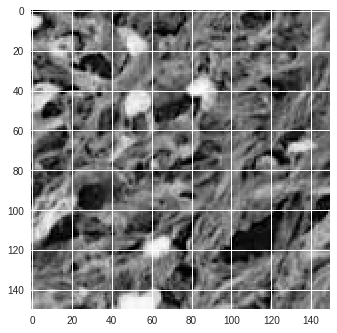

In [7]:
plt.imshow(train_data[3])

In [8]:
test_data

array([[[0.89019608, 0.87843137, 0.85882353, ..., 0.76470588,
         0.70196078, 0.65882353],
        [0.62745098, 0.61960784, 0.60392157, ..., 0.86666667,
         0.81960784, 0.7254902 ],
        [0.52941176, 0.52156863, 0.50196078, ..., 0.90588235,
         0.83921569, 0.6745098 ],
        ...,
        [0.5372549 , 0.57254902, 0.57254902, ..., 0.57647059,
         0.56470588, 0.59215686],
        [0.54901961, 0.58823529, 0.58039216, ..., 0.58039216,
         0.56862745, 0.59215686],
        [0.57647059, 0.60784314, 0.57254902, ..., 0.6       ,
         0.58823529, 0.6       ]],

       [[0.1372549 , 0.18823529, 0.23529412, ..., 0.22352941,
         0.22352941, 0.30196078],
        [0.16470588, 0.17647059, 0.2       , ..., 0.16862745,
         0.17647059, 0.23529412],
        [0.17254902, 0.17647059, 0.2       , ..., 0.16470588,
         0.17647059, 0.21176471],
        ...,
        [0.16078431, 0.22745098, 0.29803922, ..., 0.30196078,
         0.29019608, 0.29019608],
        [0.2

## Step 2
At this point, the data has been split into training and testing sets and normalized. We will now design a fully connected neural network for texture classification. 


![alt text](http://adventuresinmachinelearning.com/wp-content/uploads/2017/04/CNN-example-block-diagram.jpg)


( Image from http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ )

When designing a fully connected network for classification, we have several decisions to make.

**Network Architecuture**
* How many layers will our network have ?
* How many convolutional filters per layer ?
    * What is an appropriate filter size ? 
* What is an appropriate batch size, learning rate and number of training epochs ?

**Data input**
* Do we use the raw data ?
    * RGB or just gray channel ?
* Does the use of different colorspaces lead to better results for a given network architecture ?
* Can we use any of the texture features from the previous lab as inputs to this model ?
* How does data augmentation affect the results ? 

Other considerations, we will not be exploring :
* What is the trade-off between input data sizes and batch size ?
* Is the GPU always the appropriate platform for training ?
* How does hardware influence inputs and batch sizes for a given desired accuracy ?

In [0]:
# Define the data shapes based on your decision to use rgb or grayscale or other colorpsaces or texture features or 
# some combination of these inputs
num_classes = 8 
input_shape = (nrows, ncols,1)
train_data = train_data.reshape(train_data.shape[0], nrows, ncols, 1)
test_data = test_data.reshape(test_data.shape[0], nrows, ncols, 1)

In [12]:
train_data.shape

(4000, 150, 150, 1)

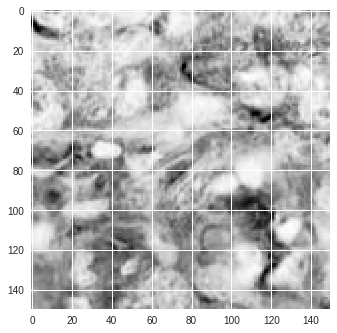

In [13]:
plt.imshow(train_data[0][:,:,0])

## Step 3
Design your network here using Keras

In [30]:
# Create your network
model = []
model = Sequential()

# Add input layer
#model.add(tf.keras.layers.InputLayer(train_data[0].shape))
# Add fully connected layers 

# See keras.io for Conv2D, MaxPool2D, Dropout documentation
#model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
#model.add(MaxPool2D(pool_size = (3,3)))
#model.add(Flatten())
#model.add(Dropout(.2))
#model.add(Dense(64, activation=tf.nn.relu))

# Add final output layer - This should have as many neurons as the number
# of classes we are trying to identify
#model.add( )
#model.add(Flatten())
#model.add(Dense(8, activation=tf.nn.softmax))

model.add(Conv2D(32,(5,5), input_shape=train_data[0].shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Conv2D(64,(5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 270856    
Total params: 322,952
Trainable params: 322,952
Non-trainable params: 0
_________________________________________________________________


## Step 4
Compile the model you designed. Compiltation of the Keras model results in the initialization of model weights and sets other model properties.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

## Step 5
Train model

In [33]:

y = model.fit(train_data, train_labels, epochs=62, batch_size=100, verbose=True)

Epoch 1/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.9551 - acc: 0.6080
Epoch 2/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.9312 - acc: 0.6288
Epoch 3/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.8486 - acc: 0.6623
Epoch 4/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.8817 - acc: 0.6515
Epoch 5/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.8160 - acc: 0.6680
Epoch 6/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7881 - acc: 0.6915
Epoch 7/62
2600/4000 [==================>...........] - ETA: 1s - loss: 0.8451 - acc: 0.6596

4000/4000 [==============================] - 5s 1ms/step - loss: 0.8377 - acc: 0.6665
Epoch 8/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7519 - acc: 0.7082
Epoch 9/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7587 - acc: 0.7043
Epoch 10/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7337 - acc: 0.7180
Epoch 11/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7432 - acc: 0.7192
Epoch 12/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7142 - acc: 0.7123
Epoch 13/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.7133 - acc: 0.7433

4000/4000 [==============================] - 5s 1ms/step - loss: 0.7056 - acc: 0.7502
Epoch 14/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6638 - acc: 0.7515
Epoch 15/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6624 - acc: 0.7548
Epoch 16/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6304 - acc: 0.7865
Epoch 17/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6434 - acc: 0.7637
Epoch 18/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5595 - acc: 0.8062
Epoch 19/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.5506 - acc: 0.8082

4000/4000 [==============================] - 5s 1ms/step - loss: 0.5529 - acc: 0.8062
Epoch 20/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5638 - acc: 0.8127
Epoch 21/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6089 - acc: 0.7750
Epoch 22/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5024 - acc: 0.8242
Epoch 23/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5524 - acc: 0.8108
Epoch 24/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.4962 - acc: 0.8257
Epoch 25/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.4742 - acc: 0.8306

4000/4000 [==============================] - 5s 1ms/step - loss: 0.4878 - acc: 0.8267
Epoch 26/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.4820 - acc: 0.8300
Epoch 27/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.4499 - acc: 0.8550
Epoch 28/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5114 - acc: 0.8237
Epoch 29/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.4115 - acc: 0.8680
Epoch 30/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5624 - acc: 0.8275
Epoch 31/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.4220 - acc: 0.8776

4000/4000 [==============================] - 5s 1ms/step - loss: 0.4200 - acc: 0.8750
Epoch 32/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3809 - acc: 0.8802
Epoch 33/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3937 - acc: 0.8720
Epoch 34/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3876 - acc: 0.8725
Epoch 35/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3735 - acc: 0.8773
Epoch 36/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3233 - acc: 0.9085
Epoch 37/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.3397 - acc: 0.8973

4000/4000 [==============================] - 5s 1ms/step - loss: 0.3414 - acc: 0.8932
Epoch 38/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3770 - acc: 0.8778
Epoch 39/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3214 - acc: 0.9055
Epoch 40/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.3160 - acc: 0.9090
Epoch 41/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2897 - acc: 0.9158
Epoch 42/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2542 - acc: 0.9363
Epoch 43/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.2536 - acc: 0.9336

4000/4000 [==============================] - 5s 1ms/step - loss: 0.2588 - acc: 0.9315
Epoch 44/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.4034 - acc: 0.8785
Epoch 45/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2453 - acc: 0.9430
Epoch 46/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2493 - acc: 0.9327
Epoch 47/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2285 - acc: 0.9415
Epoch 48/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2153 - acc: 0.9460
Epoch 49/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.1933 - acc: 0.9582

4000/4000 [==============================] - 5s 1ms/step - loss: 0.1962 - acc: 0.9583
Epoch 50/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2149 - acc: 0.9415
Epoch 51/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.1757 - acc: 0.9645
Epoch 52/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2510 - acc: 0.9305
Epoch 53/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.1796 - acc: 0.9585
Epoch 54/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2129 - acc: 0.9468
Epoch 55/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.1709 - acc: 0.9645

4000/4000 [==============================] - 5s 1ms/step - loss: 0.1715 - acc: 0.9640
Epoch 56/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5267 - acc: 0.8835
Epoch 57/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.1803 - acc: 0.9655
Epoch 58/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.1625 - acc: 0.9658
Epoch 59/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.1998 - acc: 0.9490
Epoch 60/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.2055 - acc: 0.9493
Epoch 61/62
3300/4000 [=======================>......] - ETA: 0s - loss: 0.1413 - acc: 0.9691

4000/4000 [==============================] - 5s 1ms/step - loss: 0.1406 - acc: 0.9703
Epoch 62/62
4000/4000 [==============================] - 5s 1ms/step - loss: 0.1411 - acc: 0.9723


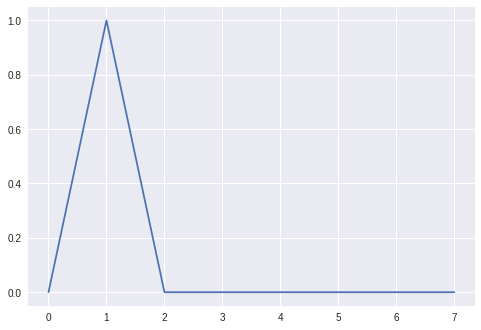

In [53]:
plt.plot(train_labels[8])

In [20]:
train_data.shape

(4000, 150, 150)

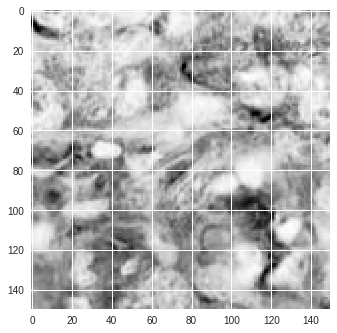

In [21]:
plt.imshow(train_data[0])

## Step 6
See how your model performs by uisng it for inference.
* What is the accuracy of classification ?
* Change your model, re-compile and test. Can you improve the accuracy of the model ?


In [34]:
# predict labels - use the test set for prediction
pred_labels = model.predict(test_data)
pred_labels

array([[6.7636156e-01, 5.1082619e-02, 1.4085068e-02, ..., 0.0000000e+00,
        1.5323222e-04, 6.5696291e-08],
       [2.1285548e-24, 2.6302348e-05, 1.3742317e-29, ..., 0.0000000e+00,
        9.9997365e-01, 7.5422271e-34],
       [3.5748926e-05, 1.8856829e-06, 2.8626795e-04, ..., 1.2575549e-03,
        4.1203347e-18, 9.9838054e-01],
       ...,
       [2.4036569e-07, 4.4038463e-01, 1.1213421e-08, ..., 0.0000000e+00,
        5.3975689e-01, 9.0100724e-15],
       [3.4892830e-01, 2.6354519e-01, 3.4657183e-01, ..., 1.3560699e-14,
        1.4712794e-09, 2.2694590e-02],
       [2.8747347e-06, 1.6481854e-07, 7.0730775e-06, ..., 9.3978667e-01,
        3.1763031e-20, 6.0199849e-02]], dtype=float32)

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# We need to convert the categorical array test_labels into a vector
# in order to use it in the calculation of the confusion matrix

mat = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred_labels,axis=1))
acc = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(pred_labels,axis=1))
print(acc)
print(mat)

0.677
[[ 87   2  31   0  11   0   0   0]
 [ 11  58   2  16  26   0   6   0]
 [ 59   2  51   0   5   0   0   7]
 [  0  13   0  84   3   0   7   0]
 [ 34  20  15   4  59   0   5   0]
 [  0   0   0   0   0 123   0   2]
 [  1  15   0   3   6   0 108   0]
 [  0   0   4   0   0  13   0 107]]


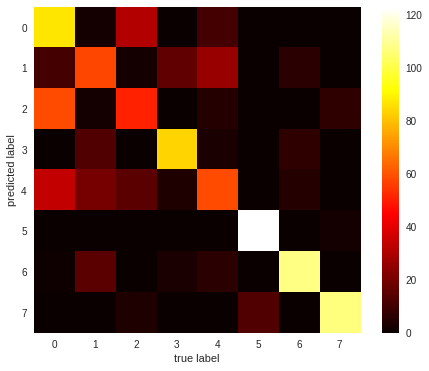

In [36]:
plt.figure(figsize=(8,6))
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Assignment
* In Step 3 design your own network
* Does the model perform better if you use all three RGB channels ?
* How does the performance change when using the La*b colorspace ?


In [0]:

# Load data as RGB
y = np.load(os.path.join(data_dir, 'rgb01.npz'))
labels = y['labels']
data_rgb = y['rgb_data']
label_str = y['label_str']
label_str = label_str.tolist() # this is to convert label_str back to a dictionary
y = []

print(data_rgb.shape)
for ii in range(2,6):
    filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
    print('loading ', filename)
    y = np.load(filename)
    labels = np.append(labels, y['labels'], axis=0)
    data_rgb = np.append(data_rgb, y['rgb_data'])
    print(data_rgb.shape)
    y = []

data_rgb = data_rgb.astype('float')
data_rgb = data_rgb.reshape(5000, 150, 150, 3)

print( data_rgb.shape )
print( labels.shape )

num_images, nrows, ncols, dims = data_rgb.shape